In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet

In [2]:
df = pd.read_csv("../data/zillow_data.csv", dtype={'RegionName': str})

In [4]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
df.shape

(14723, 272)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(48), object(5)
memory usage: 30.6+ MB


In [3]:
remove_regionid_sizerank = df.drop(['RegionID', 'SizeRank'], axis=1)
remove_regionid_sizerank['RegionName'].apply('{:0>5}'.format)

0        60657
1        75070
2        77494
3        60614
4        79936
         ...  
14718    01338
14719    03293
14720    40404
14721    81225
14722    89155
Name: RegionName, Length: 14723, dtype: object

In [5]:
remove_regionid_sizerank['Metro'].unique()

array(['Chicago', 'Dallas-Fort Worth', 'Houston', 'El Paso', 'New York',
       'San Francisco', 'The Villages', 'Nashville',
       'Los Angeles-Long Beach-Anaheim', 'Austin', 'Charlotte', 'McAllen',
       'Atlanta', 'Washington', 'San Antonio', 'Clarksville', 'St. Louis',
       'Oklahoma City', 'Phoenix', 'Baltimore', 'Miami-Fort Lauderdale',
       'Brownsville', 'Virginia Beach', 'Seattle', 'Cleveland',
       'Ann Arbor', 'Boston', 'Kansas City', 'Sacramento', 'Tucson',
       'Jacksonville', 'Napa', 'San Diego', 'Albuquerque', 'Hartford',
       'Las Vegas', 'Lancaster', 'Fresno', 'Denver', 'Detroit', 'Vallejo',
       'Pittsburgh', 'Columbus', 'Portland', 'Riverside', 'Yuma',
       'Ithaca', 'Springfield', 'Fort Myers', nan, 'Cincinnati', 'Tampa',
       'Columbia', 'Lafayette-West Lafayette', 'Fayetteville', 'Raleigh',
       'Kennewick', 'College Station', 'Hagerstown', 'Philadelphia',
       'Richmond', 'Indianapolis', 'Tulsa', 'Orlando', 'Greenville',
       'Ventura', 'S

In [9]:
zillow_inside_out = ['San Antonio', 'Austin', 'New Orleans', 
                     'Washington', 'Nashville', 'Charlotte', 
                     'San Diego', 'Raleigh', 'Miami-Fort Lauderdale']

In [10]:
zillow_outside_in = ['Riverside', 'Sacramento', 'San Diego', 
                     'Portland', 'San Francisco', 'Fresno', 
                     'Jacksonville', 'Austin', 'Seattle', 
                     'Denver']

In [11]:
zillow_hottest_2018 = ['San Jose', 'Raleigh', 'Seattle', 
                       'Charlotte', 'San Francisco', 'Austin', 
                       'Denver', 'Nashville', 'Portland', 'Dallas-Fort Worth'    
                        ]

In [12]:
word_of_mouth = ['Boise City', 'New York']

In [13]:
zillow_interest = list(set(zillow_outside_in)| set(zillow_hottest_2018) | set(word_of_mouth))
zillow_interest

['Austin',
 'San Jose',
 'Fresno',
 'Seattle',
 'Denver',
 'New York',
 'Jacksonville',
 'Raleigh',
 'San Francisco',
 'Charlotte',
 'San Diego',
 'Sacramento',
 'Boise City',
 'Portland',
 'Dallas-Fort Worth',
 'Riverside',
 'Nashville']

In [4]:
melted = pd.melt(remove_regionid_sizerank, 
                 id_vars=['RegionName', 'City', 'State', 
                          'Metro', 'CountyName'], 
                 var_name='time')

In [7]:
melted.groupby('time')

In [5]:
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)

In [6]:
melted_metros_means = melted.groupby(['Metro', 'time']).aggregate({'value': 'mean'})

In [18]:
melted_metros_means

value
Metro      time                     
Aberdeen   1996-04-01   95910.000000
           1996-05-01   95840.000000
           1996-06-01   95800.000000
           1996-07-01   95760.000000
           1996-08-01   95710.000000
...                              ...
Zanesville 2017-12-01  115783.333333
           2018-01-01  116350.000000
           2018-02-01  116850.000000
           2018-03-01  118050.000000
           2018-04-01  119116.666667

[185765 rows x 1 columns]

In [19]:
z_interest_melted = melted_metros_means.query("Metro == @zillow_interest")

In [20]:
z_interest_melted

value
Metro   time                     
Austin  1996-04-01  177344.594595
        1996-05-01  177183.783784
        1996-06-01  177131.081081
        1996-07-01  177174.324324
        1996-08-01  177300.000000
...                           ...
Seattle 2017-12-01  561174.468085
        2018-01-01  569081.560284
        2018-02-01  575012.056738
        2018-03-01  580377.304965
        2018-04-01  583936.170213

[4505 rows x 1 columns]

In [21]:
z_interest_reset_index = z_interest_melted.reset_index(level='Metro')

In [22]:
z_interest_reset_index

,Metro,value
time,,
1996-04-01,Austin,177344.594595
1996-05-01,Austin,177183.783784
1996-06-01,Austin,177131.081081
1996-07-01,Austin,177174.324324
1996-08-01,Austin,177300.000000
...,...,...
2017-12-01,Seattle,561174.468085
2018-01-01,Seattle,569081.560284
2018-02-01,Seattle,575012.056738


In [23]:
ds, yhat_lower, yhat, yhat_upper, metro_name = [], [], [], [], []

for metro in zillow_interest:
    group = z_interest_reset_index.loc[z_interest_reset_index["Metro"] == metro]
    df_for_prophet = group.reset_index().drop('Metro', axis=1).rename(columns={'time': 'ds', 'value': 'y'})
    
    m = Prophet(interval_width=0.95)
    m.fit(df_for_prophet)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    ds.extend(forecast['ds'].values)
    yhat_lower.extend(forecast['yhat_lower'].values)
    yhat.extend(forecast['yhat'].values)
    yhat_upper.extend(forecast['yhat_upper'].values)
    metro_name.extend(np.repeat(metro, forecast.shape[0]))    

data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Metro': metro_name}
df = pd.DataFrame(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [24]:
z_interest_merge = z_interest_reset_index.reset_index().merge(df, left_on=['time', 'Metro'], right_on=['ds', 'Metro'])
z_interest_merge['log_value'] = np.log(z_interest_merge['value'])
z_interest_merge['log_yhat'] = np.log(z_interest_merge['yhat'])

IndexingError: Too many indexers

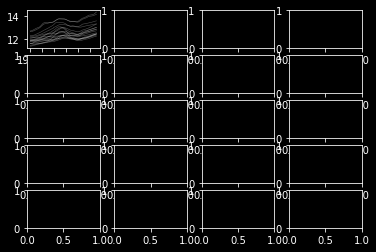

In [25]:
# enforce a specific plot style sheet
plt.style.use("dark_background")

# create a color palette
palette = plt.get_cmap("Paired")

fig, axs = plt.subplots(nrows=5, ncols=4)

# counter will store the feature index to use when highlighting a particular teammate in each subplot
counter = 0

# begin the nested for loop to access each individual subplot within the 3x3 grid
# note: we are subsetting each subplot via axs[row, col]
for row in range(axs.shape[0]):
    for col in range(axs.shape[1]):
        # plot every feature in each subplot as a white line
        for metro in zillow_interest:
            metro_plot = z_interest_merge[z_interest_merge['Metro'] == metro]
            axs[row, col].plot(metro_plot["time"],
                           metro_plot["log_value"],
                           marker="",
                           color="white", 
                           linewidth=0.6,
                           alpha=0.3)
        # for each subplot, plot only one non-"hour" feature - via counter - in color
        # note: this where we'll input counter directly inside of palette()
        axs[row, col].plot(metro_plot["time"],
                           metro_plot["log_value"].iloc[:, counter],
                           marker="",
                           color=palette(counter), 
                           linewidth=2.4,
                           alpha=0.9)
        # set xlim and ylim for each subplot
        #axs[row, col].set_xlim(0,10)
        axs[row, col].set_ylim(11,14)
        
        # remove x-axis tick marks from the first two rows of subplots
        if row in [0, 1]:
            axs[row, col].tick_params(labelbottom=False)
        # remove the y-axis tick marks from the second and third columns of subplots
        if col in [1, 2]:
            axs[row, col].tick_params(labelleft=False)          

        # assign each subplot a title based on the one non-"hour" feature that was highlighted in color
        axs[row, col].set_title(metro, 
                                loc="left", 
                                fontsize=12, 
                                fontweight=0, 
                                color=palette(counter))
        
        # now that we're done with this subplot, add one to counter so the next teammate is highlighted
        counter += 1
            
# assign an overall title
fig.suptitle("Average number of commits over time by each team member", 
             fontsize=13, 
             fontweight=0,
             color="white", 
             style="italic", 
             y=1.02)
 
# label axes
fig.text(0.5, 0.01, "Time (in number of hours since start of hackathon)", ha="center", va="center")
fig.text(0.01, 0.5, "Number of commits", ha="center", va="center", rotation='vertical')

# adjust layout so things aren't so squished
fig.tight_layout()

# export figure as PNG file
fig.savefig("visuals/class_small_multiples_example.png",
            dpi=200,
            bbox_inches="tight")

---

In [ ]:
for metro in zillow_interest:
    metro_plot = z_interest_merge[z_interest_merge['Metro'] == metro]
    plt.figure(figsize=(15,10))
    
    plt.plot(metro_plot['time'], 
             metro_plot['log_value'], 
             label='actual', 
             linewidth=3, 
            )
    
    plt.plot(metro_plot['time'], 
             metro_plot['log_yhat'], 
             label='pred', 
             linewidth=3)
    
    #plt.xaxis()
    plt.legend(loc='best')
    plt.title(f'Monthly Mean Property Sales Price in {metro} Metro Area', fontsize=16)
    plt.ylabel("Log (2018 Dollars)")

In [ ]:
# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(20,10))

# create a color palette
NUM_COLORS = 22
palette = plt.get_cmap('hsv')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=palette)
num=0

for metro in zillow_interest:
    num+=1
    metro_plot = z_interest_merge[z_interest_merge['Metro'] == metro]
    
    # Find the right spot on the plot
    plt.subplot(5,4, num)
 
    # Plot the lineplot
    plt.plot(metro_plot['time'], 
             metro_plot['log_value'], 
             color=scalarMap.to_rgba(num), 
             linewidth=1.9, 
             alpha=0.9, 
             label=metro)
 
    # Same limits for everybody!
    plt.ylim(11,14.5)
 
#   # Not ticks everywhere
#     if num in range(7) :
#         plt.tick_params(labelbottom='off')
#     if num not in [1,4,7] :
#         plt.tick_params(labelleft='off')
 
    # Add title
    plt.title(metro, loc='left', fontsize=12, fontweight=0, color=scalarMap.to_rgba(num))


In [26]:
metros_of_interest = ['San Jose', 'Nashville', 'Dallas-Fort Worth', 'Denver', 'Raleigh', 'Austin', 'Charlotte']

In [27]:
san_jose_zips, nashville_zips, dfw_zips, denver_zips, raleigh_zips, austin_zips, charlotte_zips = [],[],[],[],[],[],[]

In [ ]:
print(melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == 'San Jose').any()))

In [ ]:
sj= melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == 'San Jose').any())

In [ ]:
melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == 'San Jose').any())['RegionName'].value_counts().shape

In [ ]:
zips=melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == 'San Jose').any())['RegionName'].unique()

In [ ]:
sj.info()

In [ ]:
!pwd

In [31]:
for metro in metros_of_interest:
    met = melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == metro).any())
    zippies = met['RegionName'].unique()
    
    ds, yhat_lower, yhat, yhat_upper, zipcode = [], [], [], [], []
    
    for zippy in zippies:
        group = met[met['RegionName'] == zippy].drop(['State', 'City', 'Metro', 'CountyName'], 
                                                     axis=1)
        
        df_for_prophet = group.reset_index().drop('RegionName', 
                                                  axis=1).rename(columns={'time': 'ds', 'value': 'y'})
        
        m = Prophet(interval_width=0.8, 
                    n_changepoints=25, 
                    changepoint_range=0.9, 
                    changepoint_prior_scale=0.18)
        
        m.fit(df_for_prophet)
        future = m.make_future_dataframe(periods=36, freq='M')
        forecast = m.predict(future)
        ds.extend(forecast['ds'].values)
        yhat_lower.extend(forecast['yhat_lower'].values)
        yhat.extend(forecast['yhat'].values)
        yhat_upper.extend(forecast['yhat_upper'].values)
        zipcode.extend(np.repeat(zippy, forecast.shape[0]))
    
    zip_data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Zip_code': zipcode}
    zip_df = pd.DataFrame(zip_data)
    zip_merge = met.merge(zip_df, left_on=['time', 'RegionName'], right_on=['ds', 'Zip_code'])
    zip_merge['log_value'] = np.log(zip_merge['value'])
    zip_merge['log_yhat'] = np.log(zip_merge['yhat'])
    
    zip_df[zip_df['ds']>='2018-01-01'].to_csv(f"../write_data/{metro}_future.csv")
    zip_merge.to_csv(f"../write_data/{metro}.csv")
    print(f"{metro} done")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

San Jose done


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Nashville done


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Dallas-Fort Worth done


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Denver done


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Raleigh done


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Austin done


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Charlotte done


In [10]:
metro = 'Minneapolis-St Paul'

met = melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == metro).any())
zippies = met['RegionName'].unique()

ds, yhat_lower, yhat, yhat_upper, zipcode = [], [], [], [], []

for zippy in zippies:
    group = met[met['RegionName'] == zippy].drop(['State', 'City', 'Metro', 'CountyName'], 
                                                 axis=1)

    df_for_prophet = group.reset_index().drop('RegionName', 
                                              axis=1).rename(columns={'time': 'ds', 'value': 'y'})

    m = Prophet(interval_width=0.8, 
                n_changepoints=25, 
                changepoint_range=0.9, 
                changepoint_prior_scale=0.18)

    m.fit(df_for_prophet)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    ds.extend(forecast['ds'].values)
    yhat_lower.extend(forecast['yhat_lower'].values)
    yhat.extend(forecast['yhat'].values)
    yhat_upper.extend(forecast['yhat_upper'].values)
    zipcode.extend(np.repeat(zippy, forecast.shape[0]))

zip_data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Zip_code': zipcode}
zip_df = pd.DataFrame(zip_data)
zip_merge = met.merge(zip_df, left_on=['time', 'RegionName'], right_on=['ds', 'Zip_code'])
zip_merge['log_value'] = np.log(zip_merge['value'])
zip_merge['log_yhat'] = np.log(zip_merge['yhat'])

zip_df[zip_df['ds']>='2018-01-01'].to_csv(f"../write_data/{metro}_future.csv")
zip_merge.to_csv(f"../write_data/{metro}.csv")
print(f"{metro} done")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Minneapolis-St Paul done


In [12]:
metro = 'Miami-Fort Lauderdale'

met = melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == metro).any())
zippies = met['RegionName'].unique()

ds, yhat_lower, yhat, yhat_upper, zipcode = [], [], [], [], []

zippy = '33415'
group = met[met['RegionName'] == zippy].drop(['State', 'City', 'Metro', 'CountyName'], 
                                             axis=1)

df_for_prophet = group.reset_index().drop('RegionName', 
                                          axis=1).rename(columns={'time': 'ds', 'value': 'y'})

m = Prophet(interval_width=0.8, 
            n_changepoints=25, 
            changepoint_range=0.9, 
            changepoint_prior_scale=0.18)

m.fit(df_for_prophet)
future = m.make_future_dataframe(periods=36, freq='M')
forecast = m.predict(future)
ds.extend(forecast['ds'].values)
yhat_lower.extend(forecast['yhat_lower'].values)
yhat.extend(forecast['yhat'].values)
yhat_upper.extend(forecast['yhat_upper'].values)
zipcode.extend(np.repeat(zippy, forecast.shape[0]))

zip_data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Zip_code': zipcode}
zip_df = pd.DataFrame(zip_data)
zip_merge = met.merge(zip_df, left_on=['time', 'RegionName'], right_on=['ds', 'Zip_code'])
zip_merge['log_value'] = np.log(zip_merge['value'])
zip_merge['log_yhat'] = np.log(zip_merge['yhat'])

zip_df[zip_df['ds']>='2018-01-01'].to_csv(f"../write_data/{metro}_future.csv")
zip_merge.to_csv(f"../write_data/{metro}.csv")
print(f"{metro} done")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Miami-Fort Lauderdale done


In [7]:
metro = "Salt Lake City"

met = melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == metro).any())
zippies = met['RegionName'].unique()

ds, yhat_lower, yhat, yhat_upper, zipcode = [], [], [], [], []

for zippy in zippies:
    group = met[met['RegionName'] == zippy].drop(['State', 'City', 'Metro', 'CountyName'], 
                                                 axis=1)

    df_for_prophet = group.reset_index().drop('RegionName', 
                                              axis=1).rename(columns={'time': 'ds', 'value': 'y'})

    m = Prophet(interval_width=0.8, 
                n_changepoints=25, 
                changepoint_range=0.9, 
                changepoint_prior_scale=0.18)

    m.fit(df_for_prophet)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    ds.extend(forecast['ds'].values)
    yhat_lower.extend(forecast['yhat_lower'].values)
    yhat.extend(forecast['yhat'].values)
    yhat_upper.extend(forecast['yhat_upper'].values)
    zipcode.extend(np.repeat(zippy, forecast.shape[0]))
    
zip_data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Zip_code': zipcode}
zip_df = pd.DataFrame(zip_data)
zip_merge = met.merge(zip_df, left_on=['time', 'RegionName'], right_on=['ds', 'Zip_code'])
zip_merge['log_value'] = np.log(zip_merge['value'])
zip_merge['log_yhat'] = np.log(zip_merge['yhat'])

zip_df[zip_df['ds']>='2018-01-01'].to_csv(f"../write_data/{metro}_future.csv")
zip_merge.to_csv(f"../write_data/{metro}.csv")
print(f"{metro} done")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Salt Lake City done


---

In [ ]:
for metro in metros_of_interest:
    met = melted.groupby(['RegionName']).filter(lambda x: (x['Metro'] == metro).any())
    zippies = met['RegionName'].unique()
    
    ds, yhat_lower, yhat, yhat_upper, zipcode = [], [], [], [], []
    
    for zippy in zippies:
        group = met[met['RegionName'] == zippy].drop(['State', 'City', 'Metro', 'CountyName'], 
                                                     axis=1)
        
        df_for_prophet = group.reset_index().drop('RegionName', 
                                                  axis=1).rename(columns={'time': 'ds', 'value': 'y'})
        
        m = Prophet(interval_width=0.8, 
                    n_changepoints=25, 
                    changepoint_range=0.9, 
                    changepoint_prior_scale=0.18)
        
        m.fit(df_for_prophet)
        future = m.make_future_dataframe(periods=36, freq='M')
        forecast = m.predict(future)
        ds.extend(forecast['ds'].values)
        yhat_lower.extend(forecast['yhat_lower'].values)
        yhat.extend(forecast['yhat'].values)
        yhat_upper.extend(forecast['yhat_upper'].values)
        zipcode.extend(np.repeat(zippy, forecast.shape[0]))
    
    zip_data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Zip_code': zipcode}
    zip_df = pd.DataFrame(zip_data)
    zip_merge = met.merge(zip_df, left_on=['time', 'RegionName'], right_on=['ds', 'Zip_code'])
    zip_merge['log_value'] = np.log(zip_merge['value'])
    zip_merge['log_yhat'] = np.log(zip_merge['yhat'])
    
    zip_df[zip_df['ds']>='2018-01-01'].to_csv(f"../write_data/{metro}_future.csv")
    zip_merge.to_csv(f"../write_data/{metro}.csv")
    print(f"{metro} done")

---

In [ ]:
met = melted.groupby(['RegionName']).filter(lambda x: (x['RegionName'] == '95023').any())
met

In [ ]:
group = met[met['RegionName'] == '95023'].drop(['State', 'City', 'Metro', 'CountyName'], axis=1)
group

In [ ]:
group.reset_index().drop(['RegionName','index'], axis=1).rename(columns={'time': 'ds', 'value': 'y'})

In [ ]:
ds, yhat_lower, yhat, yhat_upper, zipcode = [], [], [], [], []
met = melted.groupby(['RegionName']).filter(lambda x: (x['RegionName'] == '95023').any())
    
group = met[met['RegionName'] == '95023'].drop(['State', 'City', 'Metro', 'CountyName'], axis=1)
df_for_prophet = group.reset_index().drop(['RegionName','index'], axis=1).rename(columns={'time': 'ds', 'value': 'y'})

m = Prophet(interval_width=0.95)
m.fit(df_for_prophet)
future = m.make_future_dataframe(periods=120, freq='M')
forecast = m.predict(future)
ds.extend(forecast['ds'].values)
yhat_lower.extend(forecast['yhat_lower'].values)
yhat.extend(forecast['yhat'].values)
yhat_upper.extend(forecast['yhat_upper'].values)
zipcode.extend(np.repeat('95023', forecast.shape[0]))

zip_data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Zip_code': zipcode}
zip_df = pd.DataFrame(zip_data)
zip_merge = met.merge(zip_df, left_on=['time', 'RegionName'], right_on=['ds', 'Zip_code'])
zip_merge['log_value'] = np.log(zip_merge['value'])
zip_merge['log_yhat'] = np.log(zip_merge['yhat'])

zip_df[zip_df['ds']>='2018-01-01'].to_csv(f"../write_data/ten_yr_95023_future.csv")
zip_merge.to_csv(f"../write_data/ten_yr_95023.csv")

In [ ]:
melted.groupby(['RegionName']).filter(lambda x: (x['RegionName'] == '07106').any())

In [ ]:
top_and_bot_five = ['07106', '29661', '64110', '20621', '07103', '71238', '10128', '11222', '16625', '70090']

for zippy in top_and_bot_five:
    met = melted.groupby(['RegionName']).filter(lambda x: (x['RegionName'] == zippy).any())
    
    ds, yhat_lower, yhat, yhat_upper, zipcode = [], [], [], [], []
    
    group = met[met['RegionName'] == zippy].drop(['State', 'City', 'Metro', 'CountyName'], axis=1)
    df_for_prophet = group.reset_index().drop('RegionName', axis=1).rename(columns={'time': 'ds', 'value': 'y'})

    m = Prophet(interval_width=0.8)
    m.fit(df_for_prophet)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    ds.extend(forecast['ds'].values)
    yhat_lower.extend(forecast['yhat_lower'].values)
    yhat.extend(forecast['yhat'].values)
    yhat_upper.extend(forecast['yhat_upper'].values)
    zipcode.extend(np.repeat(zippy, forecast.shape[0]))
    
    zip_data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Zip_code': zipcode}
    zip_df = pd.DataFrame(zip_data)
    zip_merge = met.merge(zip_df, left_on=['time', 'RegionName'], right_on=['ds', 'Zip_code'])
    zip_merge['log_value'] = np.log(zip_merge['value'])
    zip_merge['log_yhat'] = np.log(zip_merge['yhat'])
    
    zip_df[zip_df['ds']>='2018-01-01'].to_csv(f"../write_data/{zippy}_future.csv")
    zip_merge.to_csv(f"../write_data/{zippy}.csv")

In [ ]:
ds, yhat_lower, yhat, yhat_upper, zipcode = [], [], [], [], []

for zip_i in zips[:3]:
    group = sj[sj['RegionName'] == zip_i].drop(['State', 'City', 'Metro', 'CountyName'], axis=1)
    df_for_prophet = group.reset_index().drop('RegionName', axis=1).rename(columns={'time': 'ds', 'value': 'y'})
    
    m = Prophet(interval_width=0.95)
    m.fit(df_for_prophet)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    ds.extend(forecast['ds'].values)
    yhat_lower.extend(forecast['yhat_lower'].values)
    yhat.extend(forecast['yhat'].values)
    yhat_upper.extend(forecast['yhat_upper'].values)
    zipcode.extend(np.repeat(zip_i, forecast.shape[0]))    

zip_data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Zip_code': zipcode}
zip_df = pd.DataFrame(zip_data)

In [ ]:
zip_df

In [ ]:
zip_merge = sj.merge(zip_df, left_on=['time', 'RegionName'], right_on=['ds', 'Zip_code'])
zip_merge['log_value'] = np.log(zip_merge['value'])
zip_merge['log_yhat'] = np.log(zip_merge['yhat'])

In [ ]:
zip_merge

In [ ]:
melted.groupby(['Metro', 'RegionName', 'time']).aggregate({'value': 'mean'})

In [ ]:
for metro in zillow_interest:
    metro_plot = z_interest_merge[z_interest_merge['Metro'] == metro]
    plt.figure(figsize=(15,10))
    
    plt.plot(metro_plot['time'], 
             metro_plot['log_value'], 
             label=metro, 
             linewidth=3, 
            )
    plt.legend(loc='best')
    plt.title(f'Monthly Mean Property Sales Price in {metro} Metro Area', fontsize=16)
    plt.ylabel("Log (2018 Dollars)")

---

In [ ]:
np.exp(12.0)

In [ ]:
np.exp(12.6)

In [ ]:
z_in_out_melted = melted_metros_means.query("Metro == @zillow_inside_out")

In [ ]:
z_in_out_melted.shape

In [ ]:
z_in_out_reset_index = z_in_out_melted.reset_index(level='Metro')

In [ ]:
ds, yhat_lower, yhat, yhat_upper, metro_name = [], [], [], [], []

for metro in zillow_inside_out:
    group = z_in_out_reset_index.loc[z_in_out_reset_index["Metro"] == metro]
    
    df = group.reset_index().drop('Metro', axis=1).rename(columns={'time': 'ds', 'value': 'y'})
    
    m = Prophet(interval_width=0.95)
    m.fit(df)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    ds.extend(forecast['ds'].values)
    yhat_lower.extend(forecast['yhat_lower'].values)
    yhat.extend(forecast['yhat'].values)
    yhat_upper.extend(forecast['yhat_upper'].values)
    metro_name.extend(np.repeat(metro, forecast.shape[0]))    

data = {'ds': ds, 'yhat_lower': yhat_lower, 'yhat': yhat, 'yhat_upper': yhat_upper, 'Metro': metro_name}
df = pd.DataFrame(data)


In [ ]:
df[df['ds'] >= '2018-04-01']

In [ ]:
z_in_out_merge = z_in_out_reset_index.reset_index().merge(df, left_on=['time', 'Metro'], right_on=['ds', 'Metro'])
z_in_out_merge

In [ ]:
z_in_out_merge[z_in_out_merge['time'] == '2017-01-01']

In [ ]:
z_in_out_merge['log_value'] = np.log(z_in_out_merge['value'])
z_in_out_merge['log_yhat'] = np.log(z_in_out_merge['yhat'])
z_in_out_merge

In [ ]:
z_in_out_merge.info()

In [ ]:
taco = z_in_out_merge[z_in_out_merge['Metro'] == 'Austin']

In [ ]:
taco.plot(x='time', y='log_value', kind='line')

In [ ]:
plt.figure(figsize=(20,15))
plt.plot(taco['time'], taco['log_value'], label='actual')
plt.plot(taco['time'], taco['log_yhat'], label='pred')
plt.legend(loc='best')
plt.title('Austin, Monthly Mean Propery Sales Price ')
plt.ylabel("Log (2018 Dollars)")
plt.show()

In [ ]:
for metro in zillow_inside_out:
    metro_plot = z_in_out_merge[z_in_out_merge['Metro'] == metro]
    plt.figure(figsize=(20,15))
    
    plt.plot(metro_plot['time'], 
             metro_plot['log_value'], 
             label='actual', 
             linewidth=3, 
            )
    
    plt.plot(metro_plot['time'], 
             metro_plot['log_yhat'], 
             label='pred', 
             linewidth=3)
    
    #plt.xaxis()
    plt.legend(loc='best')
    plt.title(f'Monthly Mean Property Sales Price in {metro} Metro Area', fontsize=16)
    plt.ylabel("Log (2018 Dollars)")

In [ ]:
for metro in zillow_inside_out:
    df[df['Metro'] == metro].plot(x='ds', y='yhat', label=metro, subplots=True)

In [ ]:
for metro in zillow_inside_out:
    group = z_in_out_reset_index.loc[z_in_out_reset_index["Metro"] == metro]
    
    df2 = group.reset_index().drop('Metro', axis=1).rename(columns={'time': 'ds', 'value': 'y'})
    df2.head()
#df[df['Metro'] == 'Austin']
df2

In [ ]:
test2 = z_in_out_reset_index.loc[z_in_out_reset_index["Metro"] == 'Austin']
test2.reset_index().drop('Metro', axis=1).rename(columns={'time': 'ds', 'value': 'y'})

In [ ]:
for g in z_in_out_melted.groups:
    group = z_in_out_melted.get_group(g)
    m = Prophet(interval_width=0.95)
    m.fit(group)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    print(forecast.tail())

In [ ]:
fig, ax = plt.subplots()

for key, grp in z_in_out_melted.groupby('Metro'):
    print(key)
    grp.plot(ax=ax, kind='line', figsize=(20,15), label=key)#, x='time', y='value', c=key, label=key)

plt.legend(loc='best')
plt.show();

In [ ]:
for g in z_in_out_melted.groups:
    group = z_in_out_melted.get_group(g)
    m = Prophet(interval_width=0.95)
    m.fit(group)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    print(forecast.tail())

In [ ]:
z_out_in_melted = melted_metros_means.query("Metro == @zillow_outside_in")

In [ ]:
fig2, ax2 = plt.subplots()

for key2, grp2 in z_out_in_melted.groupby('Metro'):
    print(key2)
    grp2.plot(ax=ax2, kind='line', figsize=(20,15), label=key2)#, x='time', y='value', c=key, label=key)

plt.legend(loc='best')
plt.show();

In [ ]:
z_hottest_melted = melted_metros_means.query("Metro == @zillow_hottest_2018")

In [ ]:
fig3, ax3 = plt.subplots()

for key3, grp3 in z_hottest_melted.groupby('Metro'):
    print(key3)
    grp3.plot(ax=ax3, kind='line', figsize=(20,15), label=key3)#, x='time', y='value', c=key, label=key)

plt.legend(loc='best')
plt.show();

In [ ]:
melted = melted.dropna(subset=['value'])

In [ ]:
melted['State'].value_counts()

In [ ]:
group_by_state_time = melted.groupby(['State','time']).aggregate({'value':'mean'})

In [ ]:
melted.groupby(['RegionName','time']).aggregate({'value':'mean'})

In [ ]:
group_by_state_time[['State']]

In [ ]:
plt.plot(melted.groupby('time').aggregate({'value':'mean'}))

In [ ]:
df['RegionName'].nunique()

In [ ]:
df[:20].T

In [ ]:
df_transpose_header = df.T[:7]
df_transpose_header

In [ ]:
df_transpose_prices = df.T[7:]
df_transpose_prices.head()

In [ ]:
for train_index, test_index in tscv.split(X):
     print("TRAIN:", train_index, "TEST:", test_index)

     #To get the indices 
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

tscv = TimeSeriesSplit(df_transpose_prices)

---

In [ ]:
df['CountyName'].value_counts()

In [ ]:
state_df = df.groupby(['State', 'CountyName'])

In [ ]:
only_oc_ca = state_df.get_group(('CA', 'Orange'))

In [ ]:
only_oc_ca_transpose = only_oc_ca.T[7:]

In [ ]:
only_oc_ca_transpose

In [ ]:
only_oc_ca_transpose['1996-04':'1997-01']

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(only_oc_ca_transpose);

In [ ]:
only_oc_ca_transpose.tail()

In [ ]:
model = ARIMA(np.asarray(only_oc_ca_transpose[96]), order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
model2 = ARIMA(np.asarray(only_oc_ca_transpose[96]), order=(1,1,2))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

In [ ]:
residuals2 = pd.DataFrame(model2_fit.resid)
residuals2.plot()
plt.show()
residuals2.plot(kind='kde')
plt.show()
print(residuals2.describe())

In [ ]:
model3 = ARIMA(np.asarray(only_oc_ca_transpose[96][:9]), order=(0,1,1))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())

In [ ]:
model3_fit.predict() + only_oc_ca_transpose[96][0]

In [ ]:
plt.plot(only_oc_ca_transpose[96][:9]);
plt.plot(model3_fit.predict()+ only_oc_ca_transpose[96][0]);

---

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df[df['CountyName'] == 'Wabaunsee'].describe()

In [ ]:
df_transpose = df.T

In [ ]:
prices_only = df_transpose[7:]

In [ ]:
test = prices_only[1]
test.size

In [ ]:
pd.to_datetime(df_transpose[7:].index)

In [ ]:
df_datetime = pd.concat([pd.to_datetime(df_transpose[7:].index), df_transpose[7:]])

In [ ]:
df_datetime

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(test);